In [1]:
api_key = '08LTQ7UV6OYHKN5S' # alpha-vantage

In [1]:
ticker = "BTC-USD"

In [2]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_name, start_date, end_date, interval='1d'):
    try:
        df = yf.download(stock_name, start=start_date, end=end_date, interval=interval)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
stock_data = get_stock_data(ticker, "2025-03-11", "2025-03-15", '1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
row_counts = stock_data.resample("D").size()
row_counts

,0
Datetime,
2025-03-11 00:00:00+00:00,1130
2025-03-12 00:00:00+00:00,1126
2025-03-13 00:00:00+00:00,1107
2025-03-14 00:00:00+00:00,1109


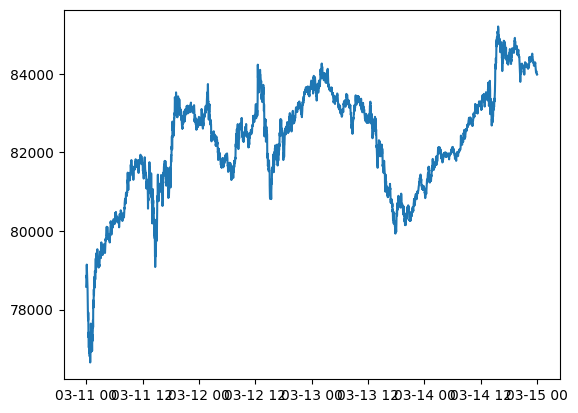

In [7]:
import matplotlib.pyplot as plt

plt.plot(stock_data['Close'])

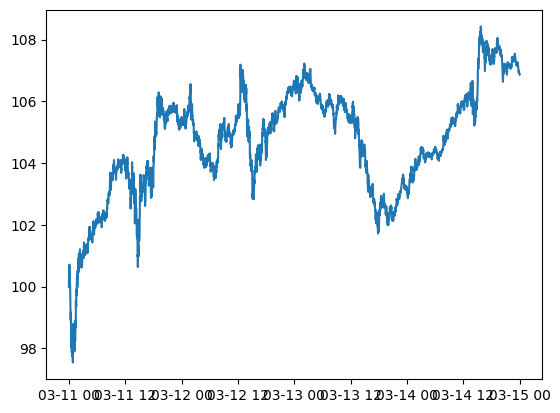

In [8]:
plt.plot(stock_data['Close'] / stock_data['Close'].iloc[0] * 100)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
stock_data.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [11]:
stock_data.columns = ['_'.join(col) for col in stock_data.columns]

In [12]:
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(BaselineRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.GRU):
            for name, param in module.named_parameters():
                if "weight_ih" in name:  # Input-hidden weights
                    nn.init.xavier_uniform_(param)
                elif "weight_hh" in name:  # Hidden-hidden weights
                    nn.init.orthogonal_(param)
                elif "bias" in name:  # Bias terms
                    nn.init.zeros_(param)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='linear')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x shape: (seq_len, batch_size, input_size)
        out, h_n = self.rnn(x)  # out.shape = (seq_len, batch_size, hidden_size)
        out = self.fc1(out[:, -1])  # Take the last output in the sequence
        out = self.fc2(self.act(out))  # out.shape = (batch_size, output_size)
        return out

In [13]:
stock_data[::-1].head()

,Close_BTC-USD,High_BTC-USD,Low_BTC-USD,Open_BTC-USD,Volume_BTC-USD
Datetime,,,,,
2025-03-14 23:58:00+00:00,83979.750000,83979.750000,83979.750000,83979.750000,0
2025-03-14 23:56:00+00:00,83984.273438,83984.273438,83984.273438,83984.273438,0
2025-03-14 23:55:00+00:00,83983.320312,83983.320312,83983.320312,83983.320312,108527616
2025-03-14 23:54:00+00:00,83993.882812,83993.882812,83993.882812,83993.882812,0
2025-03-14 23:52:00+00:00,84005.578125,84005.578125,84005.578125,84005.578125,98949120


In [14]:
stock_pcts = stock_data.pct_change()
stock_pcts_res = stock_pcts.iloc[1:]
means, stds = stock_pcts_res.mean(), stock_pcts_res.std()
stock_pcts_res_norm = (stock_pcts_res - means) / stds

In [15]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, seq_len, device='cpu'):
        self.data = data
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        idx = idx % len(self)
        X = self.data[idx: idx + self.seq_len]
        y= self.data[idx + self.seq_len]
        return torch.tensor(X, dtype=torch.float32, device=self.device), torch.tensor(y, dtype=torch.float32, device=self.device)

In [16]:
SEQ_LEN = 700
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
PARTITION = 0.8

In [19]:
stock_pcts_res_norm.drop(f'Volume_{ticker}', axis=1, inplace=True)

In [20]:
val_idx, actual_val_pred_idx = 1000, 300
data = stock_pcts_res_norm[:-val_idx].values

In [21]:
dataset = MyDataset(data, SEQ_LEN, DEVICE)

len(dataset)

train_size, test_size = int(len(dataset) * PARTITION), len(dataset) - int(len(dataset) * PARTITION)
training_data, testing_data = random_split(dataset, [train_size, test_size])

print(len(training_data))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

2216


In [22]:
NUM_LAYERS = 2
HID_DIM = 32
DROPOUT = 0.5
LR = 1e-4
NB_EPOCHS = 100
COEF = 0.5

In [23]:
input_size = data.shape[1]
hidden_size = HID_DIM
output_size = data.shape[1]
num_layers = NUM_LAYERS
dropout = DROPOUT

model = BaselineRNN(input_size, hidden_size, output_size, num_layers, dropout).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

In [24]:
from tqdm import trange, tqdm

best_val_loss = float('inf')

pbar = tqdm(range(NB_EPOCHS), desc="Epochs", unit="epoch", leave=True)
for epoch in pbar:
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss = running_loss * (1 - COEF) + loss.item() * COEF

    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            test_loss = test_loss * (1 - COEF) + criterion(output, y_batch).item() * COEF

    pbar.set_postfix({'Train Loss': f'{running_loss:.4f}', 'Val Loss': f'{test_loss:.4f}'})
    # Checkpoint if validation loss improves
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"\nModel saved at epoch {epoch+1} with val_loss: {test_loss:.4f}")


Epochs:   1%|          | 1/100 [00:01<02:29,  1.51s/epoch, Train Loss=0.7650, Val Loss=0.9452]

Model saved at epoch 1 with val_loss: 0.9452


Epochs:   2%|▏         | 2/100 [00:02<01:35,  1.03epoch/s, Train Loss=0.7651, Val Loss=0.9245]

Model saved at epoch 2 with val_loss: 0.9245


Epochs:   3%|▎         | 3/100 [00:02<01:16,  1.27epoch/s, Train Loss=0.7496, Val Loss=0.9142]

Model saved at epoch 3 with val_loss: 0.9142


Epochs:   4%|▍         | 4/100 [00:03<01:03,  1.50epoch/s, Train Loss=0.7471, Val Loss=0.9038]

Model saved at epoch 4 with val_loss: 0.9038


Epochs:   5%|▌         | 5/100 [00:03<00:56,  1.68epoch/s, Train Loss=0.7629, Val Loss=0.8929]

Model saved at epoch 5 with val_loss: 0.8929


Epochs:   6%|▌         | 6/100 [00:04<00:51,  1.81epoch/s, Train Loss=0.8112, Val Loss=0.8925]

Model saved at epoch 6 with val_loss: 0.8925


Epochs: 100%|██████████| 100/100 [00:54<00:00,  1.82epoch/s, Train Loss=0.5277, Val Loss=1.8643]


In [25]:
# Your choice
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [26]:
df_subset = stock_pcts_res_norm[-val_idx:]
def create_sequences(df):
    X = []
    for i in range(len(df) - SEQ_LEN + 1):
        X.append(torch.tensor(((df.iloc[i:i + SEQ_LEN] - means[:-1]) / stds[:-1]).values, dtype=torch.float32, device=DEVICE))
    return torch.stack(X, dim=0)

X = create_sequences(df_subset)
predictions = model(X.clone().detach())[:-1]  # Shape: (n_samples, n_features)
pred_columns = [f'Pred_{col.split("_")[0]}_{ticker}' for col in df_subset.columns]
pred_df = pd.DataFrame(predictions.detach().cpu().numpy(), index=df_subset.index[SEQ_LEN:], columns=pred_columns)

for col in pred_columns:
    df_subset[col] = pd.Series(pred_df[col], index=pred_df.index)

<ipython-input-26-1a9a83601e43>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = pd.Series(pred_df[col], index=pred_df.index)
<ipython-input-26-1a9a83601e43>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = pd.Series(pred_df[col], index=pred_df.index)
<ipython-input-26-1a9a83601e43>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [38]:
df_subset.isnull().any(axis=1)

,0
Datetime,
2025-03-14 02:23:00+00:00,True
2025-03-14 02:25:00+00:00,True
2025-03-14 02:26:00+00:00,True
2025-03-14 02:27:00+00:00,True
2025-03-14 02:28:00+00:00,True
...,...
2025-03-14 23:52:00+00:00,False
2025-03-14 23:54:00+00:00,False
2025-03-14 23:55:00+00:00,False


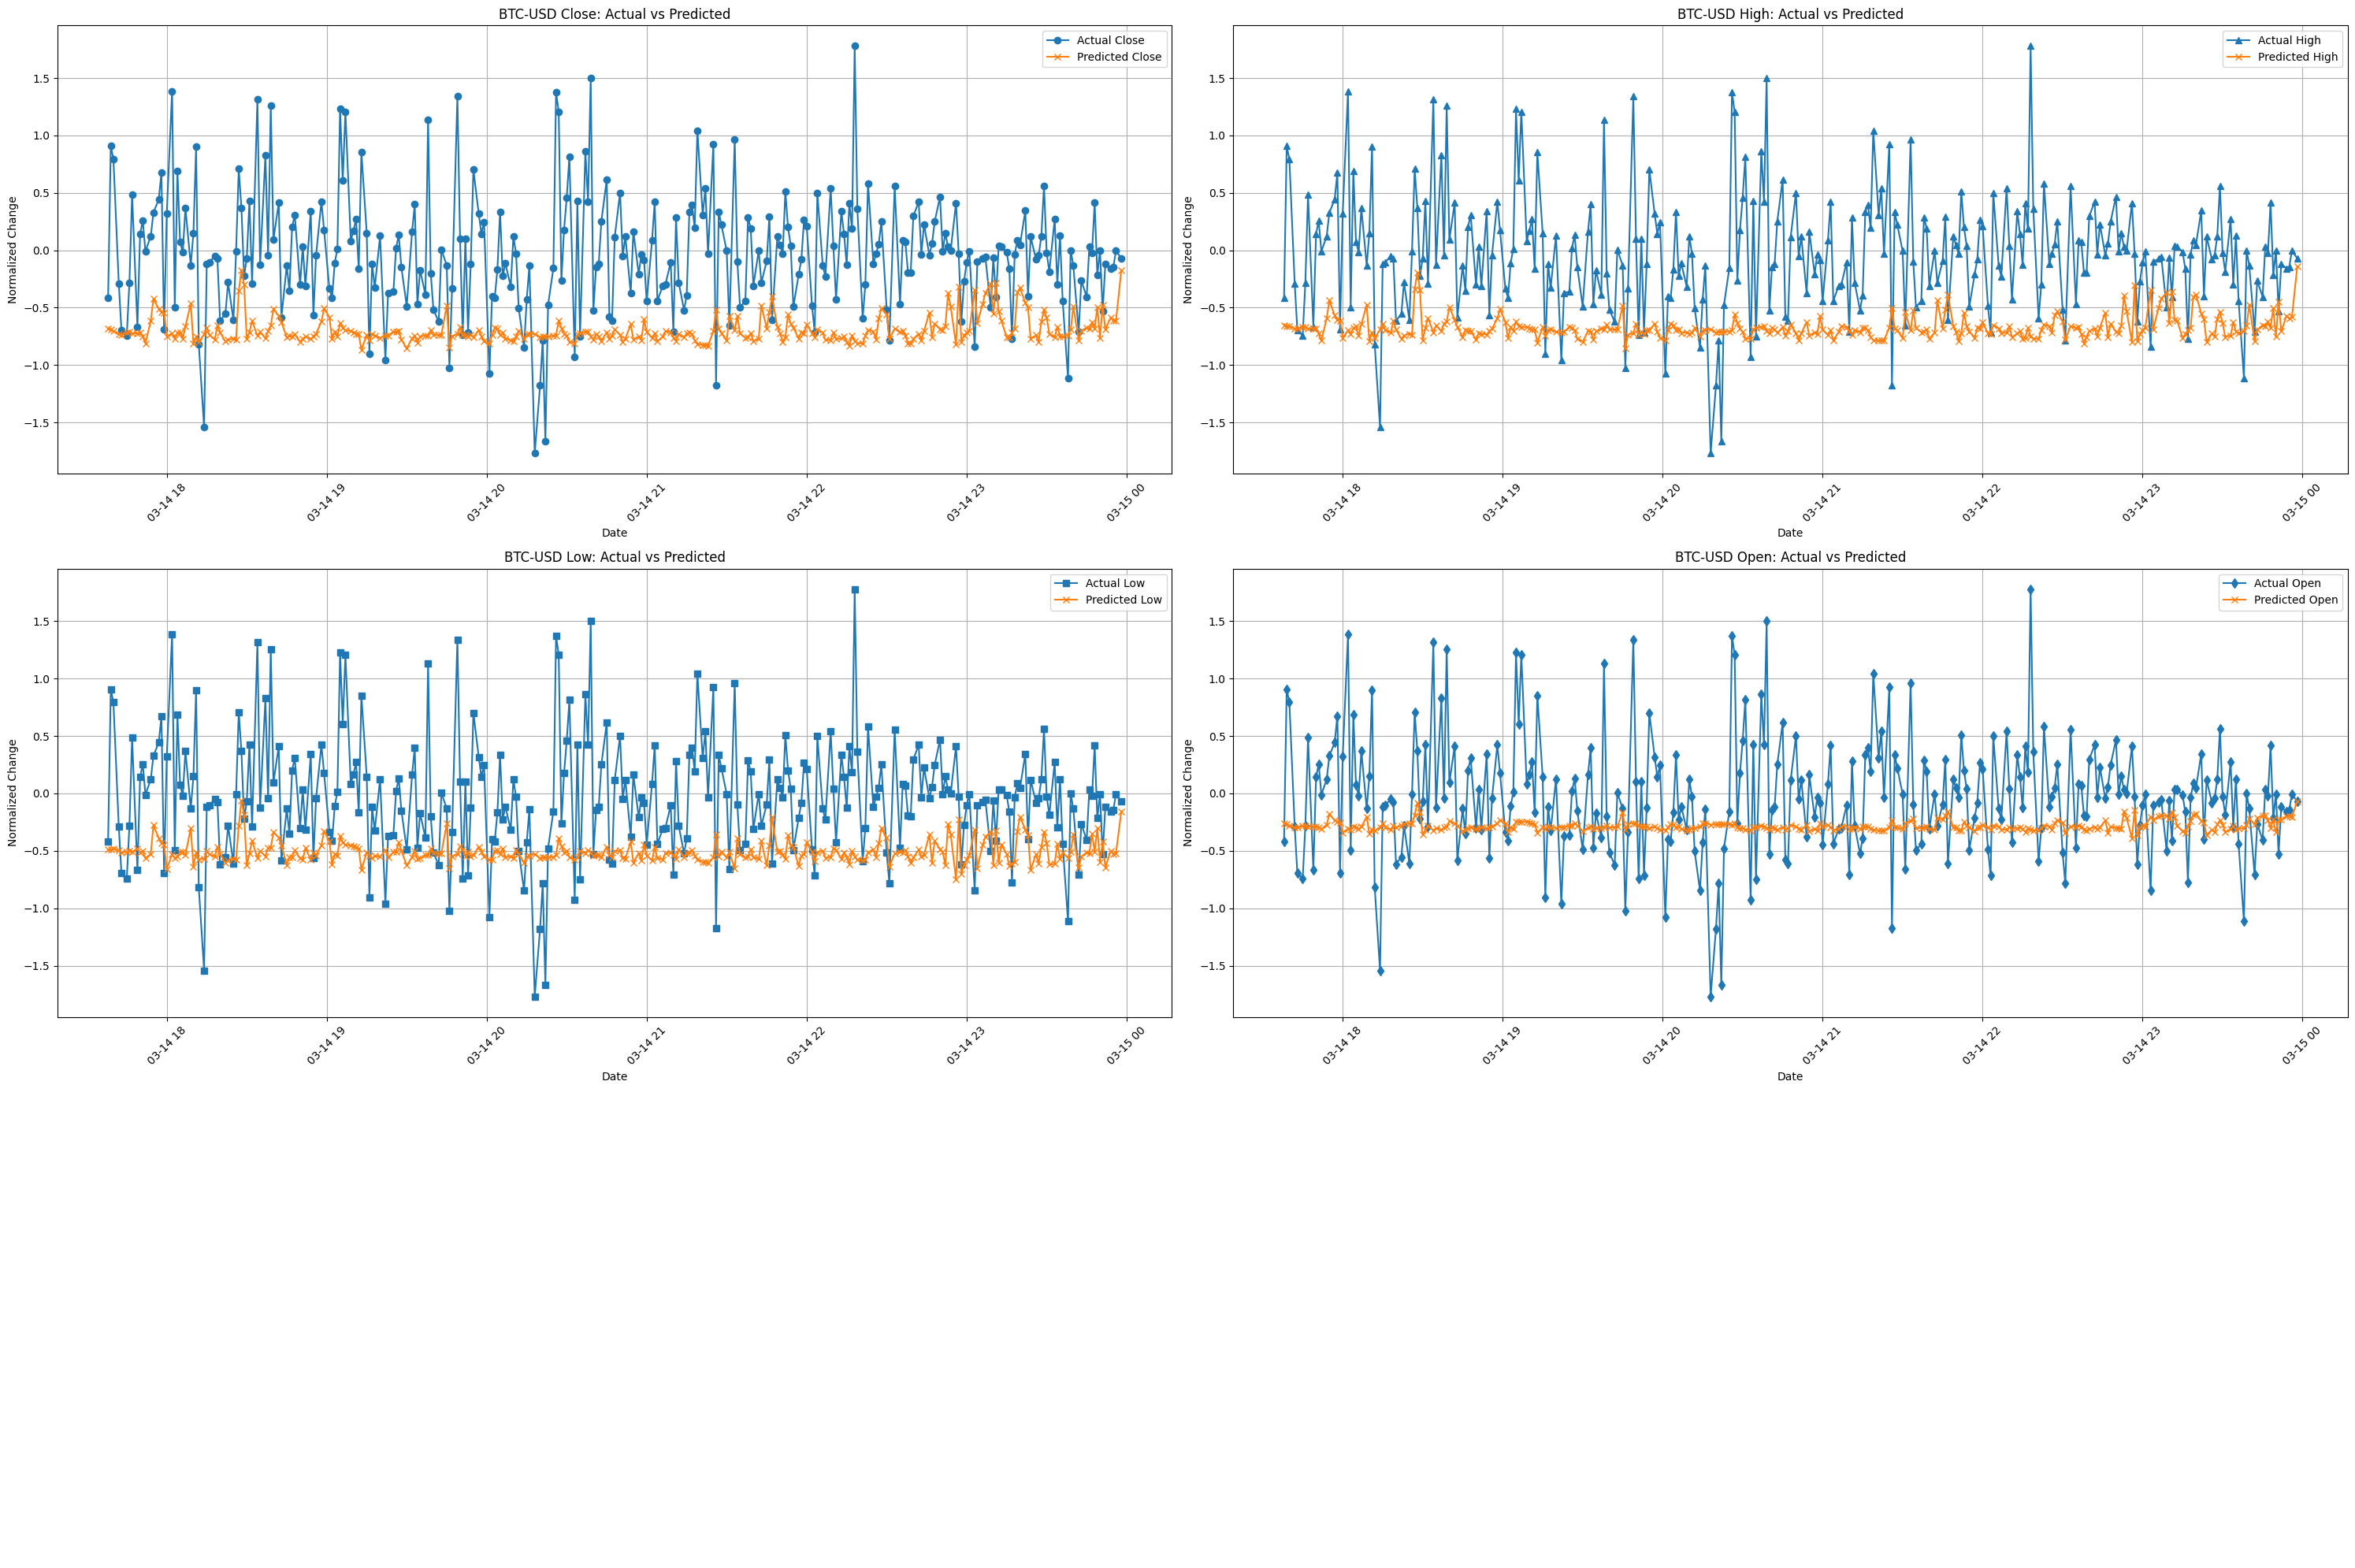

In [39]:
df_pred = df_subset[-actual_val_pred_idx:].copy()

timeline = df_pred.index

# Create figure with 6 subplots (3 rows, 2 columns)
plt.figure(figsize=(30, 20))

# 1. Close Price
plt.subplot(3, 2, 1)
plt.plot(timeline, df_pred[f'Close_{ticker}'], label='Actual Close', marker='o')
plt.plot(timeline, df_pred[f'Pred_Close_{ticker}'], label='Predicted Close', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Close: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 2. High Price
plt.subplot(3, 2, 2)
plt.plot(timeline, df_pred[f'High_{ticker}'], label='Actual High', marker='^')
plt.plot(timeline, df_pred[f'Pred_High_{ticker}'], label='Predicted High', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} High: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 3. Low Price
plt.subplot(3, 2, 3)
plt.plot(timeline, df_pred[f'Low_{ticker}'], label='Actual Low', marker='s')
plt.plot(timeline, df_pred[f'Pred_Low_{ticker}'], label='Predicted Low', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Low: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 4. Open Price
plt.subplot(3, 2, 4)
plt.plot(timeline, df_pred[f'Open_{ticker}'], label='Actual Open', marker='d')
plt.plot(timeline, df_pred[f'Pred_Open_{ticker}'], label='Predicted Open', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Open: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 6. Empty subplot or could be used for additional analysis
plt.subplot(3, 2, 6)
plt.axis('off')  # Turn off the empty subplot

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
 # 5. Volume
plt.subplot(3, 2, 5)
plt.plot(timeline, df_pred[f'Volume_{ticker}'], label='Actual Volume', marker='*')
plt.plot(timeline, df_pred[f'Pred_Volume_{ticker}'], label='Predicted Volume', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Volume: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)